## Сбор данных (создание веб-краулера)

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import re
import pandas as pd
from datetime import datetime, timedelta
from sqlalchemy import create_engine
import traceback

cookies = {
    'news_lang': 'ru',
    'nc': 'tips=1669116675432%3Bfavorites-button:1',
    'sso_checked': '1',
    'yandex_login': '',
    'yandexuid': '4418883751668766953',
    '_yasc': 'bvYHi8GFr6wiVgwnzIGbRxV1jmn9isOWGNAJOxGLT7gEOCeBN0eS96hYsvk=',
    '_ym_uid': '16687727324320845',
    '_ym_d': '1668772732',
    'vid': 'c4a038b4868be81c',
    'Session_id': 'noauth:1669019784',
    'mda2_beacon': '1669019784785',
    '_ym_isad': '2',
    'tmr_lvid': '52390132f1b93bbd91c4c20fb582a7b7',
    'tmr_lvidTS': '1668772731725',
    'tmr_detect': '0%7C1669277547765',
}

headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
    # Requests sorts cookies= alphabetically
    # 'Cookie': 'news_lang=ru; nc=tips=1669116675432%3Bfavorites-button:1; sso_checked=1; yandex_login=; yandexuid=4418883751668766953; _yasc=bvYHi8GFr6wiVgwnzIGbRxV1jmn9isOWGNAJOxGLT7gEOCeBN0eS96hYsvk=; _ym_uid=16687727324320845; _ym_d=1668772732; vid=c4a038b4868be81c; Session_id=noauth:1669019784; mda2_beacon=1669019784785; _ym_isad=2; tmr_lvid=52390132f1b93bbd91c4c20fb582a7b7; tmr_lvidTS=1668772731725; tmr_detect=0%7C1669277547765',
    'Referer': 'https://dzen.ru/news?issue_tld=ru',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36',
    'sec-ch-ua': '"Google Chrome";v="107", "Chromium";v="107", "Not=A?Brand";v="24"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
}

# Функция для обработки и вывода времени
def parse_date(s_date):
    months = {'января': '01',
              'февраля': '02',
              'марта': '03',
              'апреля': '04',
              'мая': '05',
              'июня': '06',
              'июля': '07',
              'августа': '08',
              'сентября': '09',
              'октября': '10',
              'ноября': '11',
              'декабря': '12',
              }
    
    row_date = s_date.split(' в')[0]
    #print(row_date)
    month_ = row_date.split(' ')[1].strip(' ')
    date_num = re.search(r'\d{2}', row_date).group(0)
    date = f"{date_num}.{months[month_]}.2022"
    return date

### Сбор новостей по рубрикам (на сайте Яндекс Дзен)

In [3]:
def parse_rubrics():
    rubrics = ['Политика', 'Армия и оружие', 'Общество', 'ЖКХ', 'Религия', 'Экология', 'Здоровье', 'Путешествия', 
               'Транспорт', 'Экономика', 'Энергетика', 'Недвижимость', 'Финансы', 'В мире', 'Спорт', 'Автоспорт',
               'Баскетбол', 'Футбол', 'Хоккей', 'Фигурное катание', 'Происшествия', 'Культура', 'Театры', 'Музыка',
               'Кино', 'Технологии', 'Игры', 'Гаджеты', 'Интернет', 'Наука', 'Космос']
    rubrics_links = ['rubric/politics', 'rubric/army', 'rubric/society', 'rubric/communal', 'rubric/religion',
                     'rubric/ecology', 'rubric/health', 'rubric/travels', 'rubric/vehicle',  'rubric/business',
                     'rubric/energy', 'rubric/realty', 'rubric/finances', 'rubric/world', 'rubric/sport',
                     'rubric/auto_racing', 'rubric/basketball', 'rubric/football', 'rubric/hockey',
                     'rubric/figure_skating', 'rubric/incident', 'rubric/culture', 'rubric/theaters',
                     'rubric/music', 'rubric/movies', 'rubric/computers', 'rubric/games', 'rubric/gadgets',
                     'rubric/internet', 'rubric/science', 'rubric/cosmos']

    rubricsAndLinks = list(zip(rubrics, rubrics_links))
    df_rubricsAndLinks = pd.DataFrame(rubricsAndLinks, columns=['rubric', 'rubric_link'])

    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    dates = []
    times = []
    data = []
    stories = []

    for i, row in df_rubricsAndLinks.iterrows():
        link = row['rubric_link']
        r = session.get(f'https://dzen.ru/news/{link}?issue_tld=ru')

        soup = BeautifulSoup(r.text)
        script_text = soup.find_all('script')[3].contents[0]
        data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", script_text, flags=re.S).group(1))

        story_rubric = row['rubric']
    
        for stories_top in data['news']['top']:
        
            story_id = stories_top['id']
            story_title = stories_top['title']
            story_annotation = stories_top['annotation']
            story_url = stories_top['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_top['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
        for stories_feed in data['news']['feed']:
        
            story_id = stories_feed['id']
            story_title = stories_feed['title']
            story_annotation = stories_feed['annotation']
            story_url = stories_feed['url']
            instory_url = story_url.replace('/story/', '/instory/')
            story_time = stories_feed['time']
            if 'вчера' in story_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', story_time) is not None:
                date = parse_date(story_time)
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', story_time).group(0)
                story_time = f'{date} {time}'
        
            stories.append([story_rubric, story_id, story_title, story_annotation, story_url, instory_url, story_time])
    
    
    story_headers = ['rubric', 'id', 'title', 'annotation', 'story_url', 'instory_url', 'time']
    df_stories = pd.DataFrame(stories, columns=story_headers)

    return df_stories

#parse_rubrics()

### Сбор похожих новостей при переходе к каждой новости (на сайте Яндекс Дзен)

In [11]:
%%time
def parse_main():
    df_stories = parse_rubrics()
    df_instory = df_stories[['rubric', 'id', 'instory_url']]
    more_stories = []
    
    session = requests.Session()
    session.headers.update(headers)
    session.cookies.update(cookies)

    for i, row in df_stories.iterrows():
        url = row['instory_url']
        more = session.get(url)
        more_soup = BeautifulSoup(more.text)
        more_script_text = more_soup.find_all('script')[3].contents[0]
        more_data = json.loads(re.search(r"window.Ya.Neo.dataSource=({.*?});", more_script_text, flags=re.S).group(1))
                               
        more_info = more_data['news']['instoryPage'][0]
        docs = more_info['docs']
    
        more_rubric = row['rubric']
        more_idMain = row['id']
        more_instoryUrl = row['instory_url']
            
        for doc in docs:
        
            more_id = doc['docId']
            more_title = doc['title'][0]['text']  
            more_text = doc['text'][0]['text'] 
            more_source = doc['sourceName']
            more_url = doc['url']
            more_time = doc['time']
            if 'вчера' in more_time:
                date = (datetime.now() - timedelta(days=1)).strftime('%d.%m.%Y')
                time = re.search(r'(?<=вчера в )\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            elif re.search(r'\d{2} \w+ \w+ \d{2}:\d{2}', more_time) is not None:
                date = parse_date(more_time)
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
            else:
                date = datetime.now().strftime('%d.%m.%Y')
                time = re.search(r'\d{2}:\d{2}', more_time).group(0)
                more_time = f'{date} {time}'
   
            more_stories.append([more_rubric, more_idMain, more_title, more_text, more_source, more_instoryUrl, more_url, more_time])
            
    more_stories_headers = ['rubric', 'story_id', 'title', 'text', 'sourceName', 'instory_url', 'url', 'time']
    df_more_stories = pd.DataFrame(more_stories, columns=more_stories_headers)
    
    main_rubrics = []
    for i, row in df_more_stories.iterrows():
        if row['rubric'] == 'Политика' or row['rubric'] == 'Армия и оружие':
            main_rubric = 'Политика'
        elif row['rubric'] == 'Общество' or row['rubric'] == 'ЖКХ' or row['rubric'] == 'Религия' or row['rubric'] == 'Экология' or row['rubric'] == 'Здоровье' or row['rubric'] == 'Путешествия' or row['rubric'] == 'Транспорт':
            main_rubric = 'Общество'
        elif row['rubric'] == 'Экономика' or row['rubric'] == 'Энергетика' or row['rubric'] == 'Недвижимость' or row['rubric'] == 'Финансы':
            main_rubric = 'Экономика'
        elif row['rubric'] == 'В мире':
            main_rubric = 'В мире'
        elif row['rubric'] == 'Спорт' or row['rubric'] == 'Автоспорт' or row['rubric'] == 'Баскетбол' or row['rubric'] == 'Футбол' or row['rubric'] == 'Хоккей' or row['rubric'] == 'Фигурное катание':
            main_rubric = 'Спорт'
        elif row['rubric'] == 'Происшествия':
            main_rubric = 'Происшествия'
        elif row['rubric'] == 'Культура' or row['rubric'] == 'Театры' or row['rubric'] == 'Музыка' or row['rubric'] == 'Кино':
            main_rubric = 'Культура'
        elif row['rubric'] == 'Технологии' or row['rubric'] == 'Игры' or row['rubric'] == 'Гаджеты' or row['rubric'] == 'Интернет':
            main_rubric = 'Технологии'
        elif row['rubric'] == 'Наука' or row['rubric'] == 'Космос':
            main_rubric = 'Наука'
        else:
            main_rubric = 'Другое'
        
        main_rubrics.append(main_rubric)
                             
    df_more_stories.insert(loc=0, column='main_rubric', value=main_rubrics)
    return df_more_stories

parse_main()

CPU times: user 34.5 s, sys: 1.9 s, total: 36.4 s
Wall time: 3min 1s


,main_rubric,rubric,story_id,title,text,sourceName,instory_url,url,time
0,Политика,Политика,872961276,19FortyFive: Россия победила Запад в экономиче...,"Запад пришел в ужас от того, что России удалос...",Царьград,https://dzen.ru/news/instory/19FortyFive_Rossi...,https://by.tsargrad.tv/news/19fortyfive-rossij...,14.12.2022 15:37
1,Политика,Политика,872961276,Россия победила Запад в экономической войне – ...,"""Финансовая кампания не разрушила российскую э...",ИА Новороссия,https://dzen.ru/news/instory/19FortyFive_Rossi...,https://novorosinform.org/rossiya-pobedila-zap...,14.12.2022 15:33
2,Политика,Политика,872961276,19FortyFive: РФ поставками энергоресурсов побе...,"По словам автора статьи Роберта Фарли, санкции...",Первый Севастопольский,https://dzen.ru/news/instory/19FortyFive_Rossi...,https://sev.tv/news/82157.html?utm_source=yxne...,14.12.2022 15:28
3,Политика,Политика,872961276,19FortyFive: России удалось победить западные ...,"Роберт Фарли заключил, что РФ удалось победить...",Аргументы и Факты,https://dzen.ru/news/instory/19FortyFive_Rossi...,https://aif.ru/money/economy/19fortyfive_rossi...,14.12.2022 15:27
4,Политика,Политика,872961276,19FortyFive: Россия смогла победить Запад в эк...,Россия смогла победить западные государства в ...,Инфо24,https://dzen.ru/news/instory/19FortyFive_Rossi...,https://info24.ru/news/19fortyfive-rossiya-pob...,14.12.2022 15:24
...,...,...,...,...,...,...,...,...,...
3796,Наука,Космос,876961699,Прибор для мягкой посадки «Луны-25» прошел вхо...,Доплеровский измеритель скорости и дальности Д...,ТАСС,https://dzen.ru/news/instory/Pribor_dlyamyagko...,https://tass.ru/kosmos/16585189?utm_source=yxn...,14.12.2022 01:02
3797,Наука,Космос,876963643,Первая за полвека лунная миссия пилотируемого ...,Персонал ВМС США вылавливает капсулу корабля O...,Naked Science,https://dzen.ru/news/instory/Pervaya_zapolveka...,https://naked-science.ru/article/cosmonautics/...,12.12.2022 03:23
3798,Наука,Космос,774160052,Ровер Perseverance собрал первые образцы марси...,Продолжая миссию по исследованию геологии и кл...,Российская газета,https://dzen.ru/news/instory/Rover_Perseveranc...,https://rg.ru/2022/12/12/rover-perseverance-so...,12.12.2022 21:12
3799,Наука,Космос,883360328,Крошечный спутник тестирует возможности автома...,В мае 2022 года ракета SpaceX Falcon 9 вывела ...,AstroNews.ru,https://dzen.ru/news/instory/Kroshechnyj_sputn...,https://www.astronews.ru/cgi-bin/mng.cgi?page=...,14.12.2022 12:00


### Сохранение и чтение данных в формате xlsx

In [4]:
df1 = parse_main()

# Для mac
df1.to_excel(r'/Users/user/Documents/Книга1.xlsx')

# Для win
#df1.to_excel(r'C:\Users\User\Downloads\Книга1.xlsx')

In [5]:
# Для mac
df2 = pd.read_excel(r'/Users/user/Documents/Книга1.xlsx')

# Для win
#df2 = pd.read_excel(r'C:\Users\User\Downloads\Книга1.xlsx')

# Выражение, добавляющее к БД только новые новости
res = df1[~df1['url'].isin(df2['url'])]

#res
#df1

## Разведочный анализ данных EDA

In [6]:
# Объем данных (строк и столбцов - объектов и признаков)
df1.shape

(1416, 8)

In [7]:
# Вывод типов данных
df1.dtypes

rubric         object
story_id       object
title          object
text           object
sourceName     object
instory_url    object
url            object
time           object
dtype: object

<div class="alert alert-success"><b>Целевой признак - rubric</b>

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1416 entries, 0 to 1415
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rubric       1416 non-null   object
 1   story_id     1416 non-null   object
 2   title        1416 non-null   object
 3   text         1416 non-null   object
 4   sourceName   1416 non-null   object
 5   instory_url  1416 non-null   object
 6   url          1416 non-null   object
 7   time         1416 non-null   object
dtypes: object(8)
memory usage: 88.6+ KB


<div class="alert alert-success"><b>Пропусков в данных нет</b>

In [9]:
# Имена колонок в виде списков
df1.columns

Index(['rubric', 'story_id', 'title', 'text', 'sourceName', 'instory_url',
       'url', 'time'],
      dtype='object')

In [10]:
# Кол-во пропусков во всем датафрейме
df1.isnull().sum()

rubric         0
story_id       0
title          0
text           0
sourceName     0
instory_url    0
url            0
time           0
dtype: int64

In [11]:
# Статистика распределения этих значений в % виде
df1['rubric'].value_counts(normalize=True)

Происшествия    0.218220
Культура        0.183616
В мире          0.110169
Политика        0.096045
Экономика       0.085452
Общество        0.082627
Наука           0.081215
Спорт           0.080508
Технологии      0.062147
Name: rubric, dtype: float64

In [12]:
# Исследование целевого (target) признака - рубрики 
print('Кол-во уникальных значений: ', df1['rubric'].nunique())
print('Список уникальных значений: ', df1['rubric'].unique())
print('Статистика распределения значений: ', df1['rubric'].value_counts(normalize=False))

Кол-во уникальных значений:  9
Список уникальных значений:  ['Политика' 'Общество' 'Экономика' 'В мире' 'Спорт' 'Происшествия'
 'Культура' 'Технологии' 'Наука']
Статистика распределения значений:  Происшествия    309
Культура        260
В мире          156
Политика        136
Экономика       121
Общество        117
Наука           115
Спорт           114
Технологии       88
Name: rubric, dtype: int64


<div class="alert alert-success"><b>Вывод: вид задачи - многоклассовая классификация</b>

In [13]:
# Описательная статистика для признака rubric
df1['rubric'].describe()

count             1416
unique               9
top       Происшествия
freq               309
Name: rubric, dtype: object

In [14]:
# Описательная статистика для всех признаков 
df1.describe().T

,count,unique,top,freq
rubric,1416,9,Происшествия,309
story_id,1416,250,853761485,100
title,1416,1295,Умер автор музыки к сериалу «Твин Пикс» Анджел...,11
text,1416,1343,Первый вице-губернатор Херсонской области Вита...,3
sourceName,1416,456,Центральная Служба Новостей,33
instory_url,1416,261,https://dzen.ru/news/instory/Umer_kompozitor_m...,100
url,1416,1365,https://www.gazeta.ru/business/news/2022/12/13...,2
time,1416,610,13.12.2022 12:39,19


### Визульный анализ

<AxesSubplot:ylabel='rubric'>

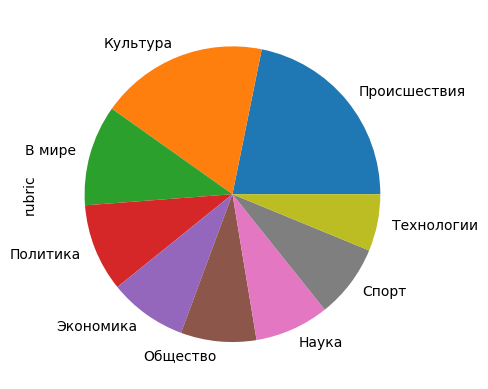

In [16]:
# Круговая(пирожковая) диаграмма
df1['rubric'].value_counts(normalize=True).plot.pie()

<AxesSubplot:>

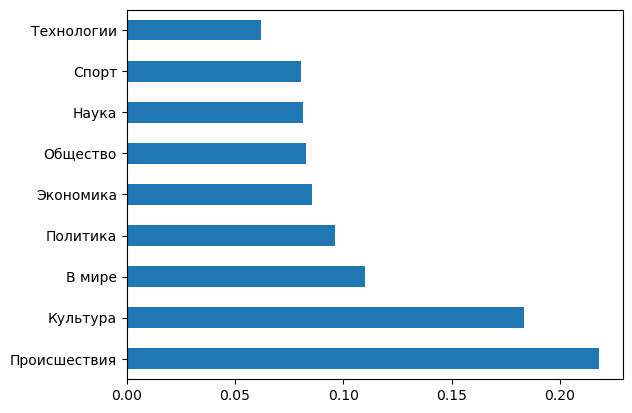

In [17]:
# Горизонтальная столбчатая диаграмма
df1['rubric'].value_counts(normalize=True).plot.barh()

In [18]:
df1['rubric'].value_counts()

Происшествия    309
Культура        260
В мире          156
Политика        136
Экономика       121
Общество        117
Наука           115
Спорт           114
Технологии       88
Name: rubric, dtype: int64

## Предварительная обработка данных (preprocessing). Обработка естественного языка NLP


Действия, выполняемые в процессе:
* сегментация и токенизация;
* стемминг;
* удаление стоп-слов;
* лемматизация.

### Удаление пробельных символов

In [19]:
import string
import re
from nltk.corpus import stopwords

def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])
def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])
def remove_multiple_spaces(text):
    return re.sub(r'\s+', ' ', text, flags=re.I)

def delete_char(): 
    prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in df1['text']]
    df_nlp = df1.loc[:, ['rubric','title','text']]
    df_nlp["text_prep"] = prep_text
    return df_nlp

df_nlp = delete_char()

df_nlp

,rubric,title,text,text_prep
0,Политика,Национальный антитеррористический комитет: ФСБ...,РИА Новости со ссылкой на информационный центр...,риа новости со ссылкой на информационный центр...
1,Политика,На российской границе задержаны 400 украинских...,Погранслужба и другие правоохранительные орган...,погранслужба и другие правоохранительные орган...
2,Политика,Более 400 украинских военных преступников были...,"Свыше 400 националистов и лиц, совершивших вое...",свыше националистов и лиц совершивших военные ...
3,Политика,ФСБ задержала на погранпунктах более 400 украи...,"""При попытке пересечения государственной грани...",при попытке пересечения государственной грани...
4,Политика,НАК: на границе России за год задержаны более ...,Погранслужба и другие правоохранительные орган...,погранслужба и другие правоохранительные орган...
...,...,...,...,...
1411,Наука,Baijiahao: бессмертие может обернуться для чел...,Человечеству придется заплатить высокую цену з...,человечеству придется заплатить высокую цену з...
1412,Наука,Baijiahao: человечество дорого заплатит за обр...,"Авторы материала напомнили, что с древних врем...",авторы материала напомнили что с древних време...
1413,Наука,Ученые: человечеству придется дорого заплатить...,"Исследователи выяснили, что в случае обретения...",исследователи выяснили что в случае обретения ...
1414,Наука,Baijiahao: бессмертие может обернуться трагеди...,Ученые проанализировали возможные последствия ...,ученые проанализировали возможные последствия ...


### Стемминг

In [20]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize

def stemmed_text():
    stemmer = SnowballStemmer("russian")
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])

    stemmed_texts_list = []
    for text in df_nlp["text_prep"]:
        tokens = word_tokenize(text)
        stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
        text = " ".join(stemmed_tokens)
        stemmed_texts_list.append(text)
    
    df_nlp["text_stem"] = stemmed_texts_list
    return df_nlp

stemmed_text()

,rubric,title,text,text_prep,text_stem
0,Политика,Национальный антитеррористический комитет: ФСБ...,РИА Новости со ссылкой на информационный центр...,риа новости со ссылкой на информационный центр...,ри новост ссылк информацион центр национальн а...
1,Политика,На российской границе задержаны 400 украинских...,Погранслужба и другие правоохранительные орган...,погранслужба и другие правоохранительные орган...,погранслужб друг правоохранительн орга рф заде...
2,Политика,Более 400 украинских военных преступников были...,"Свыше 400 националистов и лиц, совершивших вое...",свыше националистов и лиц совершивших военные ...,свыш националист лиц соверш воен преступлен пы...
3,Политика,ФСБ задержала на погранпунктах более 400 украи...,"""При попытке пересечения государственной грани...",при попытке пересечения государственной грани...,попытк пересечен государствен границ пункт про...
4,Политика,НАК: на границе России за год задержаны более ...,Погранслужба и другие правоохранительные орган...,погранслужба и другие правоохранительные орган...,погранслужб друг правоохранительн орга росс го...
...,...,...,...,...,...
1411,Наука,Baijiahao: бессмертие может обернуться для чел...,Человечеству придется заплатить высокую цену з...,человечеству придется заплатить высокую цену з...,человечеств придет заплат высок цен приобретен...
1412,Наука,Baijiahao: человечество дорого заплатит за обр...,"Авторы материала напомнили, что с древних врем...",авторы материала напомнили что с древних време...,автор материа напомн древн врем недостатк тех ...
1413,Наука,Ученые: человечеству придется дорого заплатить...,"Исследователи выяснили, что в случае обретения...",исследователи выяснили что в случае обретения ...,исследовател выясн случа обретен бессмерт чело...
1414,Наука,Baijiahao: бессмертие может обернуться трагеди...,Ученые проанализировали возможные последствия ...,ученые проанализировали возможные последствия ...,учен проанализирова возможн последств бессмерт...


### Удаление стоп-слов

In [21]:
from nltk import word_tokenize

def stopword_text():
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])
    
    sw_texts_list = []
    for text in df_nlp['text_prep']:
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
        text = " ".join(tokens)
        sw_texts_list.append(text)

    df_nlp["text_sw"] = sw_texts_list
    return df_nlp

stopword_text()

,rubric,title,text,text_prep,text_stem,text_sw
0,Политика,Национальный антитеррористический комитет: ФСБ...,РИА Новости со ссылкой на информационный центр...,риа новости со ссылкой на информационный центр...,ри новост ссылк информацион центр национальн а...,риа новости ссылкой информационный центр нацио...
1,Политика,На российской границе задержаны 400 украинских...,Погранслужба и другие правоохранительные орган...,погранслужба и другие правоохранительные орган...,погранслужб друг правоохранительн орга рф заде...,погранслужба другие правоохранительные органы ...
2,Политика,Более 400 украинских военных преступников были...,"Свыше 400 националистов и лиц, совершивших вое...",свыше националистов и лиц совершивших военные ...,свыш националист лиц соверш воен преступлен пы...,свыше националистов лиц совершивших военные пр...
3,Политика,ФСБ задержала на погранпунктах более 400 украи...,"""При попытке пересечения государственной грани...",при попытке пересечения государственной грани...,попытк пересечен государствен границ пункт про...,попытке пересечения государственной границы пу...
4,Политика,НАК: на границе России за год задержаны более ...,Погранслужба и другие правоохранительные орган...,погранслужба и другие правоохранительные орган...,погранслужб друг правоохранительн орга росс го...,погранслужба другие правоохранительные органы ...
...,...,...,...,...,...,...
1411,Наука,Baijiahao: бессмертие может обернуться для чел...,Человечеству придется заплатить высокую цену з...,человечеству придется заплатить высокую цену з...,человечеств придет заплат высок цен приобретен...,человечеству придется заплатить высокую цену п...
1412,Наука,Baijiahao: человечество дорого заплатит за обр...,"Авторы материала напомнили, что с древних врем...",авторы материала напомнили что с древних време...,автор материа напомн древн врем недостатк тех ...,авторы материала напомнили древних времен недо...
1413,Наука,Ученые: человечеству придется дорого заплатить...,"Исследователи выяснили, что в случае обретения...",исследователи выяснили что в случае обретения ...,исследовател выясн случа обретен бессмерт чело...,исследователи выяснили случае обретения бессме...
1414,Наука,Baijiahao: бессмертие может обернуться трагеди...,Ученые проанализировали возможные последствия ...,ученые проанализировали возможные последствия ...,учен проанализирова возможн последств бессмерт...,ученые проанализировали возможные последствия ...


### Лемматизация

In [22]:
from pymystem3 import Mystem

def lemmatize_text():
    mystem = Mystem()
    lemm_texts_list = []
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['…', '...', 'т.д.', 'т', 'д', '«', '»'])
    text = ""

    text_list = df_nlp['text_sw'].to_list()
    text_join = "joining".join(text_list)

    try:
        text_lem = mystem.lemmatize(text_join)
        tokens = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
        text = " ".join(tokens)
    except Exception as e:
        print(e)

    text_split = text.split("joining")
    df_nlp["text_lemm"] = text_split
    return df_nlp

lemmatize_text()

,rubric,title,text,text_prep,text_stem,text_sw,text_lemm
0,Политика,Национальный антитеррористический комитет: ФСБ...,РИА Новости со ссылкой на информационный центр...,риа новости со ссылкой на информационный центр...,ри новост ссылк информацион центр национальн а...,риа новости ссылкой информационный центр нацио...,риа новость ссылка информационный центр национ...
1,Политика,На российской границе задержаны 400 украинских...,Погранслужба и другие правоохранительные орган...,погранслужба и другие правоохранительные орган...,погранслужб друг правоохранительн орга рф заде...,погранслужба другие правоохранительные органы ...,погранслужба правоохранительный орган рф задер...
2,Политика,Более 400 украинских военных преступников были...,"Свыше 400 националистов и лиц, совершивших вое...",свыше националистов и лиц совершивших военные ...,свыш националист лиц соверш воен преступлен пы...,свыше националистов лиц совершивших военные пр...,свыше националист лицо совершать военный прест...
3,Политика,ФСБ задержала на погранпунктах более 400 украи...,"""При попытке пересечения государственной грани...",при попытке пересечения государственной грани...,попытк пересечен государствен границ пункт про...,попытке пересечения государственной границы пу...,попытке пересечение государственный граница пу...
4,Политика,НАК: на границе России за год задержаны более ...,Погранслужба и другие правоохранительные орган...,погранслужба и другие правоохранительные орган...,погранслужб друг правоохранительн орга росс го...,погранслужба другие правоохранительные органы ...,погранслужба правоохранительный орган россия г...
...,...,...,...,...,...,...,...
1411,Наука,Baijiahao: бессмертие может обернуться для чел...,Человечеству придется заплатить высокую цену з...,человечеству придется заплатить высокую цену з...,человечеств придет заплат высок цен приобретен...,человечеству придется заплатить высокую цену п...,человечеству приходиться заплатить высокий цен...
1412,Наука,Baijiahao: человечество дорого заплатит за обр...,"Авторы материала напомнили, что с древних врем...",авторы материала напомнили что с древних време...,автор материа напомн древн врем недостатк тех ...,авторы материала напомнили древних времен недо...,авторы материал напоминать древний время недос...
1413,Наука,Ученые: человечеству придется дорого заплатить...,"Исследователи выяснили, что в случае обретения...",исследователи выяснили что в случае обретения ...,исследовател выясн случа обретен бессмерт чело...,исследователи выяснили случае обретения бессме...,исследователи выяснять случай обретение бессме...
1414,Наука,Baijiahao: бессмертие может обернуться трагеди...,Ученые проанализировали возможные последствия ...,ученые проанализировали возможные последствия ...,учен проанализирова возможн последств бессмерт...,ученые проанализировали возможные последствия ...,ученые проанализировать возможный последствие ...


In [23]:
def undersempler():
    df_pr = df_nlp.loc[df_nlp['rubric'] == 'Происшествия'].head(200)
    df_other = df_nlp.loc[df_nlp['rubric'] != 'Происшествия']

    df_ml = pd.concat([df_pr, df_other])
    return df_ml

df_ml = undersempler()
df_ml

,rubric,title,text,text_prep,text_stem,text_sw,text_lemm
644,Происшествия,На границе с Косово полицией Сербии задержан к...,Сербская полиция задержала на границе с Косово...,сербская полиция задержала на границе с косово...,сербск полиц задержа границ косов корреспонден...,сербская полиция задержала границе косово корр...,сербская полиция задерживать граница косово ко...
645,Происшествия,Корреспондента телеканала «Звезда» задержали н...,"Корреспондент телеканала ""Звезда"" был задержан...",корреспондент телеканала звезда был задержан с...,корреспондент телекана звезд задержа сербск по...,корреспондент телеканала звезда задержан сербс...,корреспондент телеканал звезда задерживать сер...
646,Происшествия,Корреспондент «Звезды» задержан сербской полиц...,Полиция Сербии задержала корреспондента «Звезд...,полиция сербии задержала корреспондента «звезд...,полиц серб задержа корреспондент звезд поселк ...,полиция сербии задержала корреспондента звезды...,полиция сербия задерживать корреспондент звезд...
647,Происшествия,Полиция Сербии задержала корреспондента телека...,Корреспондента «Звезды» Алексея Дегтярёва заде...,корреспондента «звезды» алексея дегтярёва заде...,корреспондент звезд алексе дегтярев задержа се...,корреспондента звезды алексея дегтярёва задерж...,корреспондента звезда алексей дегтярев задержи...
648,Происшествия,Сербская полиция задержала корреспондента «Зве...,"Во вторник, 13 декабря, в Рашке на границе с К...",во вторник декабря в рашке на границе с косово...,вторник декабр рашк границ косов сербск полиц ...,вторник декабря рашке границе косово сербской ...,вторник декабрь рашек граница косово сербский ...
...,...,...,...,...,...,...,...
1411,Наука,Baijiahao: бессмертие может обернуться для чел...,Человечеству придется заплатить высокую цену з...,человечеству придется заплатить высокую цену з...,человечеств придет заплат высок цен приобретен...,человечеству придется заплатить высокую цену п...,человечеству приходиться заплатить высокий цен...
1412,Наука,Baijiahao: человечество дорого заплатит за обр...,"Авторы материала напомнили, что с древних врем...",авторы материала напомнили что с древних време...,автор материа напомн древн врем недостатк тех ...,авторы материала напомнили древних времен недо...,авторы материал напоминать древний время недос...
1413,Наука,Ученые: человечеству придется дорого заплатить...,"Исследователи выяснили, что в случае обретения...",исследователи выяснили что в случае обретения ...,исследовател выясн случа обретен бессмерт чело...,исследователи выяснили случае обретения бессме...,исследователи выяснять случай обретение бессме...
1414,Наука,Baijiahao: бессмертие может обернуться трагеди...,Ученые проанализировали возможные последствия ...,ученые проанализировали возможные последствия ...,учен проанализирова возможн последств бессмерт...,ученые проанализировали возможные последствия ...,ученые проанализировать возможный последствие ...


<AxesSubplot:>

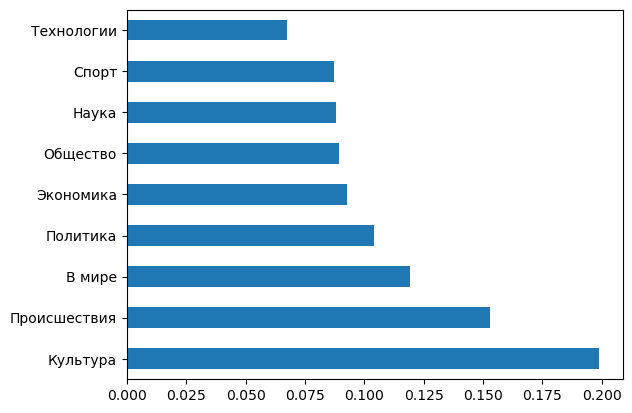

In [24]:
# Горизонтальная столбчатая диаграмма
df_ml['rubric'].value_counts(normalize=True).plot.barh()

## Создание моделей машинного обучения

### Кодирование целевой переменной. Формирование тестовой и обучающей выборок

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss

rubrics = ['Политика', 'Общество', 'Экономика', 'В мире', 'Спорт', 'Происшествия', 'Культура', 'Технологии', 'Наука']

encoder = LabelEncoder()
rubrics_list = df_ml['rubric'].to_list()
rubric_labels = encoder.fit_transform(rubrics_list)

X = df_ml['text_lemm']
#X = df_nlp['text_sw']
y = rubric_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
my_tags = rubrics

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Байесовский классификатор

In [27]:
from sklearn.naive_bayes import MultinomialNB

def nb_classifier():
    
    nb = Pipeline ([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
                   ])

    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

nb_classifier()

accuracy 0.6844783715012722
              precision    recall  f1-score   support

    Политика       0.67      0.64      0.65        47
    Общество       0.52      0.98      0.68        81
   Экономика       0.92      0.71      0.80        31
      В мире       1.00      0.20      0.33        40
       Спорт       0.89      0.49      0.63        51
Происшествия       0.71      0.96      0.82        52
    Культура       0.96      0.83      0.89        30
  Технологии       0.70      0.30      0.42        23
       Наука       0.77      0.61      0.68        38

    accuracy                           0.68       393
   macro avg       0.79      0.64      0.66       393
weighted avg       0.76      0.68      0.66       393



0.68

### Метод опорных векторов

In [28]:
from sklearn.linear_model import SGDClassifier

def sgd_classifier():
    
    sgd = Pipeline ([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),
                    ])

    sgd.fit(X_train, y_train)
    y_pred = sgd.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

sgd_classifier()

accuracy 0.8371501272264631
              precision    recall  f1-score   support

    Политика       0.68      0.64      0.66        47
    Общество       0.87      0.93      0.90        81
   Экономика       0.88      0.94      0.91        31
      В мире       0.97      0.70      0.81        40
       Спорт       0.84      0.75      0.79        51
Происшествия       1.00      0.94      0.97        52
    Культура       0.85      0.93      0.89        30
  Технологии       0.78      0.91      0.84        23
       Наука       0.66      0.82      0.73        38

    accuracy                           0.84       393
   macro avg       0.84      0.84      0.83       393
weighted avg       0.84      0.84      0.84       393



0.84

### Логистическая регрессия

In [29]:
from sklearn.linear_model import LogisticRegression

def logreg_classifier():

    logreg = Pipeline ([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('clf', LogisticRegression(n_jobs=1, C=1e5)),
                       ])

    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

logreg_classifier()

accuracy 0.816793893129771
              precision    recall  f1-score   support

    Политика       0.64      0.64      0.64        47
    Общество       0.85      0.91      0.88        81
   Экономика       0.85      0.90      0.88        31
      В мире       0.84      0.78      0.81        40
       Спорт       0.82      0.73      0.77        51
Происшествия       0.89      0.90      0.90        52
    Культура       0.97      0.93      0.95        30
  Технологии       0.81      0.74      0.77        23
       Наука       0.71      0.76      0.73        38

    accuracy                           0.82       393
   macro avg       0.82      0.81      0.81       393
weighted avg       0.82      0.82      0.82       393



/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.82

### Дерево решений 

In [30]:
from sklearn.tree import DecisionTreeClassifier

def dtree_classifier():
    
    dtree = Pipeline ([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('clf', DecisionTreeClassifier(max_depth = 2)),
                      ])

    dtree.fit(X_train, y_train)
    y_pred = dtree.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

dtree_classifier()

accuracy 0.2697201017811705
              precision    recall  f1-score   support

    Политика       0.00      0.00      0.00        47
    Общество       0.22      1.00      0.36        81
   Экономика       0.00      0.00      0.00        31
      В мире       0.00      0.00      0.00        40
       Спорт       0.00      0.00      0.00        51
Происшествия       0.89      0.46      0.61        52
    Культура       0.00      0.00      0.00        30
  Технологии       0.00      0.00      0.00        23
       Наука       1.00      0.03      0.05        38

    accuracy                           0.27       393
   macro avg       0.23      0.17      0.11       393
weighted avg       0.26      0.27      0.16       393



/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.27

### Метод K ближайщих соседей KNN

#### Для n_neighbors=3

In [31]:
from sklearn.neighbors import KNeighborsClassifier

def knn3_classifier():

    knn3 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', KNeighborsClassifier(n_neighbors=3)),
                   ])

    knn3.fit(X_train, y_train)
    y_pred = knn3.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

knn3_classifier()

accuracy 0.7862595419847328
              precision    recall  f1-score   support

    Политика       0.58      0.74      0.65        47
    Общество       0.80      0.91      0.86        81
   Экономика       0.87      0.84      0.85        31
      В мире       0.77      0.60      0.68        40
       Спорт       0.75      0.71      0.73        51
Происшествия       0.96      0.90      0.93        52
    Культура       0.90      0.93      0.92        30
  Технологии       0.75      0.65      0.70        23
       Наука       0.75      0.63      0.69        38

    accuracy                           0.79       393
   macro avg       0.79      0.77      0.78       393
weighted avg       0.79      0.79      0.79       393



0.79

#### Для n_neighbors=9

In [32]:
from sklearn.neighbors import KNeighborsClassifier

def knn9_classifier():
    
    knn9 = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', KNeighborsClassifier(n_neighbors=9)),
                   ])

    knn9.fit(X_train, y_train)
    y_pred = knn9.predict(X_test)

    print('accuracy %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred, target_names=my_tags))
    
    return round(accuracy_score(y_pred, y_test), 2)

knn9_classifier()

accuracy 0.7480916030534351
              precision    recall  f1-score   support

    Политика       0.56      0.64      0.59        47
    Общество       0.77      0.94      0.84        81
   Экономика       0.93      0.84      0.88        31
      В мире       0.71      0.42      0.53        40
       Спорт       0.72      0.61      0.66        51
Происшествия       0.84      0.94      0.89        52
    Культура       0.90      0.90      0.90        30
  Технологии       0.68      0.65      0.67        23
       Наука       0.66      0.61      0.63        38

    accuracy                           0.75       393
   macro avg       0.75      0.73      0.73       393
weighted avg       0.75      0.75      0.74       393



0.75

### Метод градиентного бустинга

In [33]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,r2_score 

def gbr_classifier():
    
    gbr = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', GradientBoostingRegressor(n_estimators=200, max_depth=12, criterion='squared_error', learning_rate=0.03, min_samples_leaf=16, min_samples_split=16)),
                   ])

    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    train_accuracy_score=gbr.score(X_train,y_train)
    test_accuracy_score=gbr.score(X_test,y_test)
    mse = mean_squared_error(y_test,y_pred)

    print(train_accuracy_score)
    print(test_accuracy_score)
    print("MSE: %.2f" % mse)
    print(r2_score(y_test,y_pred))
    
    return round(test_accuracy_score, 2)

gbr_classifier()

0.499253206226021
0.2597844731956468
MSE: 4.77
0.2597844731956468


0.26

In [34]:
from sklearn.metrics import confusion_matrix

cm = multilabel_confusion_matrix(y_test,y_pred, labels=rubrics)
cm

NameError: name 'multilabel_confusion_matrix' is not defined

![jupyter](https://pythonru.com/wp-content/uploads/2021/03/matrica-oshibok-dlya-binarnoj-klassifikacii.png)

True, если получено верное предсказание, то есть эталонные и предсказанные метки классов совпадают, и False, когда они не совпадают. Positive или Negative — названия предсказанных меток.

In [ ]:
# Пример рассчета характеристик для конкретного класса

# Чувствительность (recall)
print('TPR = %.2f' % (cm[1][1] / sum(cm[1])))

# Специфичность
print('SPC = %.2f' % (cm[0][0] / sum(cm[0])))

# Ценность + прогноза (precision)
print('PPV = %.2f' % (cm[1][1] / sum(col[1] for col in cm)))

# Ценность - прогноза
print('NPV = %.2f' % (cm[0][0] / sum(col[0] for col in cm)))

print('Acc = %.2f' % ((cm[0][0] + cm[1][1]) / sum(cm[0][])))

In [35]:
df_ml

,rubric,title,text,text_prep,text_stem,text_sw,text_lemm
644,Происшествия,На границе с Косово полицией Сербии задержан к...,Сербская полиция задержала на границе с Косово...,сербская полиция задержала на границе с косово...,сербск полиц задержа границ косов корреспонден...,сербская полиция задержала границе косово корр...,сербская полиция задерживать граница косово ко...
645,Происшествия,Корреспондента телеканала «Звезда» задержали н...,"Корреспондент телеканала ""Звезда"" был задержан...",корреспондент телеканала звезда был задержан с...,корреспондент телекана звезд задержа сербск по...,корреспондент телеканала звезда задержан сербс...,корреспондент телеканал звезда задерживать сер...
646,Происшествия,Корреспондент «Звезды» задержан сербской полиц...,Полиция Сербии задержала корреспондента «Звезд...,полиция сербии задержала корреспондента «звезд...,полиц серб задержа корреспондент звезд поселк ...,полиция сербии задержала корреспондента звезды...,полиция сербия задерживать корреспондент звезд...
647,Происшествия,Полиция Сербии задержала корреспондента телека...,Корреспондента «Звезды» Алексея Дегтярёва заде...,корреспондента «звезды» алексея дегтярёва заде...,корреспондент звезд алексе дегтярев задержа се...,корреспондента звезды алексея дегтярёва задерж...,корреспондента звезда алексей дегтярев задержи...
648,Происшествия,Сербская полиция задержала корреспондента «Зве...,"Во вторник, 13 декабря, в Рашке на границе с К...",во вторник декабря в рашке на границе с косово...,вторник декабр рашк границ косов сербск полиц ...,вторник декабря рашке границе косово сербской ...,вторник декабрь рашек граница косово сербский ...
...,...,...,...,...,...,...,...
1411,Наука,Baijiahao: бессмертие может обернуться для чел...,Человечеству придется заплатить высокую цену з...,человечеству придется заплатить высокую цену з...,человечеств придет заплат высок цен приобретен...,человечеству придется заплатить высокую цену п...,человечеству приходиться заплатить высокий цен...
1412,Наука,Baijiahao: человечество дорого заплатит за обр...,"Авторы материала напомнили, что с древних врем...",авторы материала напомнили что с древних време...,автор материа напомн древн врем недостатк тех ...,авторы материала напомнили древних времен недо...,авторы материал напоминать древний время недос...
1413,Наука,Ученые: человечеству придется дорого заплатить...,"Исследователи выяснили, что в случае обретения...",исследователи выяснили что в случае обретения ...,исследовател выясн случа обретен бессмерт чело...,исследователи выяснили случае обретения бессме...,исследователи выяснять случай обретение бессме...
1414,Наука,Baijiahao: бессмертие может обернуться трагеди...,Ученые проанализировали возможные последствия ...,ученые проанализировали возможные последствия ...,учен проанализирова возможн последств бессмерт...,ученые проанализировали возможные последствия ...,ученые проанализировать возможный последствие ...


### Искусственные нейронные сети

In [36]:
encoder = LabelEncoder()
rubrics_list = df_ml['rubric'].to_list()
rubric_labels = encoder.fit_transform(rubrics_list)
X_data = df_ml['text_lemm'].to_list()

X = encoder.fit_transform(X_data)
y = rubric_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
my_tags = rubrics

In [37]:
import random
import numpy as np

INPUT_DIM = 1
OUT_DIM = 9
H_DIM = 5

#dataset = [(df_ml['text_lemm'][i][None, ...], df_ml['rubric'][i]) for i in range(len(df_ml['rubric']))]

W1 = np.random.rand(INPUT_DIM, H_DIM)
b1 = np.random.rand(1, H_DIM)
W2 = np.random.rand(H_DIM, OUT_DIM)
b2 = np.random.rand(1, OUT_DIM)

W1 = (W1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
b1 = (b1 - 0.5) * 2 * np.sqrt(1/INPUT_DIM)
W2 = (W2 - 0.5) * 2 * np.sqrt(1/H_DIM)
b2 = (b2 - 0.5) * 2 * np.sqrt(1/H_DIM)

#Функция активации
def relu(t):
    return np.maximum(t,0)

def softmax(t):
    out = np.exp(t)
    return out / np.sum(out)

def softmax_batch(t):
    out = np.exp(t)
    return out / np.sum(out, axis=1, keepdims=True)

def sparse_cross_entropy(z,y):
    return -np.log(z[0,y])

def sparse_cross_entropy_batch(z,y):
    return -np.log(np.array([z[j, y[j]] for j in range(len(y))]))

def to_full(y, num_classes):
    y_full = np.zeros((1, num_classes))
    y_full[0, y] = 1
    return y_full

def to_full_batch(y, num_classes):
    y_full = np.zeros((len(y), num_classes))
    for j, yj in enumerate(y):
        y_full[j, yj] = 1
    return y_full

def relu_deriv(t):
    return (t >= 0).astype(float)

#Гиперпараметры нейросети
#Скорость обучения (Learning rate)
ALPHA = 0.001
#Количество эпох
NUM_EPOCHS = 100
#Размер батча
BATCH_SIZE = 1


loss_arr = []

for ep in range(NUM_EPOCHS):
    random.shuffle(dataset)
    for i in range(len(X_train) // BATCH_SIZE):
        #batch_x, batch_y = zip(*dataset[i*BATCH_SIZE : i*BATCH_SIZE+BATCH_SIZE])
        #x = np.concatenate(batch_x, axis=0)
        #y = np.array(batch_y)
        
        #Forward propagation (прямое распространение)
        t1 = x @ W1 + b1
        h1 = relu(t1)
        t2 = h1 @ W2 + b2
        z = softmax_batch(t2)
        E = sparse_cross_entropy_batch(z,y)

        #Back propagation (обратное распространение)
        y_full = to_full_batch(y, OUT_DIM)
        dE_dt2 = z - y_full
        dE_dW2 = h1.T @ dE_dt2
        dE_db2 = np.sum(dE_dt2, axis=0, keepdims=True)
        dE_dh1 = dE_dt2 @ W2.T
        dE_dt1 = dE_dh1 * relu_deriv(t1)
        dE_dW1 = x.T @ dE_dt1
        dE_db1 = np.sum(dE_dt1, axis=0, keepdims=True)

        #Update (обновление весов)
        W1 = W1 - ALPHA * dE_dW1
        b1 = b1 - ALPHA * dE_db1
        W2 = W2 - ALPHA * dE_dW2
        b2 = b2 - ALPHA * dE_db2
        W1 = W1 - ALPHA * dE_dW1
        probs = predict(x)
        pred_class = np.argmax(probs)
        class_names = ['Политика', 'Общество', 'Экономика', 'В мире', 'Спорт', 'Происшествия', 'Культура', 'Технологии', 'Наука']

        #Метрика "зависимость ошибки от итерации"
        loss_arr.append(E)
        
        #Метрика "точность предсказания" ...
        
def predict(x):
    t1 = x @ W1 + b1
    h1 = relu(t1)
    t2 = h1 @ W2 + b2
    z = softmax_batch(t2)
    return z

def calc_accuracy():
    correct = 0
    for x,y in dataset:
        z = predict(x)
        y_pred = np.argmax(z)
        if y_pred == y:
            correct += 1
    acc = correct / len(dataset)
    return acc

accuracu = calc_accuracy()
print('Accuracy:', accuracy)

#График падения ошибки
import matplotlib.pyplot as plt
plt.plot(loss_arr)
plt.show()


NameError: name 'dataset' is not defined

In [ ]:
import matplotlib.pyplot as plt

### С помощью библиотеки TensotFlow

In [38]:
#pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 MB 2.0 MB/s eta 0:00:0000:0100:04
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 859.1 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 980.5/980.5 kB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━

In [40]:
import tensorflow as tf

msg = tf.constant('Hello, TensorFlow!')
tf.print(msg)

Hello, TensorFlow!
